In [0]:
import torch
from torchtext import data
from torchtext import datasets
import random
import matplotlib.pyplot as plt
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
fields = [('category', LABEL), ('text', TEXT)]
train_data = data.TabularDataset(
                                        path = '/content/drive/My Drive/InternshipTasks/bbc-text.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

In [0]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [0]:
vars(train_data[-1])

{'text': ['What', 'is', 'a', 'Cartesian', 'Diver', '?'], 'label': 'DESC'}

In [7]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [00:10, 82.5MB/s]                           
100%|█████████▉| 399189/400000 [00:18<00:00, 21043.57it/s]

In [11]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f6f43c43b70>, {'business': 0, 'sport': 1, 'politics': 2, 'tech': 3, 'entertainment': 4})


In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,592,005 trainable parameters


In [14]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [ 0.4298,  0.8205, -1.4562,  ...,  1.4802,  0.2942,  1.3924],
        ...,
        [-0.9998, -0.0850,  0.2416,  ..., -0.0129,  0.3884, -0.0942],
        [ 0.5653,  0.4378,  1.3934,  ..., -0.0982, -0.2704,  0.6665],
        [-0.0354, -0.6715,  0.1046,  ...,  0.2001, -0.0928,  0.0383]])

In [0]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text)
        
        loss = criterion(predictions, batch.category)
        
        acc = categorical_accuracy(predictions, batch.category)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text)
            
            loss = criterion(predictions, batch.category)
            
            acc = categorical_accuracy(predictions, batch.category)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
N_EPOCHS = 10

best_valid_loss = float('inf')
TrainLoss =[]
TrainAccuracy =[]
ValLoss =[]
ValAccuracy =[]
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    TrainLoss.append(train_loss)
    TrainAccuracy.append(train_acc)
    valid_loss, valid_acc = evaluate(model, train_iterator, criterion)
    ValLoss.append(valid_loss)
    ValAccuracy.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 20s
	Train Loss: 0.455 | Train Acc: 90.44%
	 Val. Loss: 0.233 |  Val. Acc: 97.50%
Epoch: 02 | Epoch Time: 2m 21s
	Train Loss: 0.247 | Train Acc: 94.94%
	 Val. Loss: 0.133 |  Val. Acc: 97.94%
Epoch: 03 | Epoch Time: 2m 30s
	Train Loss: 0.165 | Train Acc: 96.88%
	 Val. Loss: 0.086 |  Val. Acc: 99.06%
Epoch: 04 | Epoch Time: 2m 27s
	Train Loss: 0.118 | Train Acc: 97.38%
	 Val. Loss: 0.066 |  Val. Acc: 99.19%
Epoch: 05 | Epoch Time: 2m 25s
	Train Loss: 0.090 | Train Acc: 98.31%
	 Val. Loss: 0.044 |  Val. Acc: 99.75%
Epoch: 06 | Epoch Time: 2m 29s
	Train Loss: 0.072 | Train Acc: 98.62%
	 Val. Loss: 0.035 |  Val. Acc: 99.81%
Epoch: 07 | Epoch Time: 2m 26s
	Train Loss: 0.055 | Train Acc: 99.00%
	 Val. Loss: 0.024 |  Val. Acc: 99.94%
Epoch: 08 | Epoch Time: 2m 28s
	Train Loss: 0.046 | Train Acc: 99.19%
	 Val. Loss: 0.018 |  Val. Acc: 99.94%
Epoch: 09 | Epoch Time: 2m 27s
	Train Loss: 0.034 | Train Acc: 99.69%
	 Val. Loss: 0.014 |  Val. Acc: 100.00%
Epoch: 10 | Epoch 

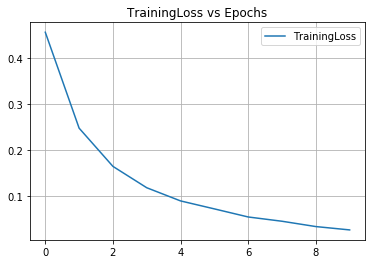

In [32]:
plt.plot(TrainLoss,label='TrainingLoss')
plt.title('TrainingLoss vs Epochs')
plt.legend()
plt.grid()



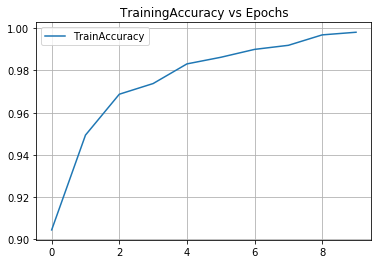

In [36]:
plt.plot(TrainAccuracy, label ='TrainAccuracy')
plt.title('TrainingAccuracy vs Epochs')
plt.legend()
plt.grid()

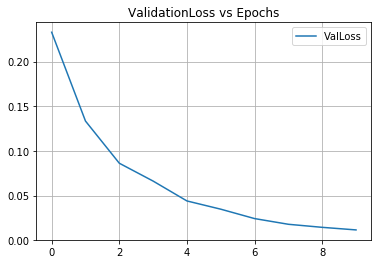

In [37]:
plt.plot(ValLoss,label = 'ValLoss')
plt.title('ValidationLoss vs Epochs')
plt.legend()
plt.grid()

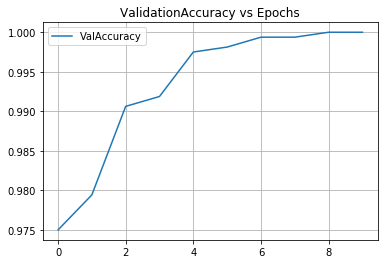

In [39]:
plt.plot(ValAccuracy,label = 'ValAccuracy')
plt.title('ValidationAccuracy vs Epochs')
plt.legend()
plt.grid()